# Creating Spherical Galaxy Clusters
![author_button](https://img.shields.io/badge/Written_By:-Eliza_Diggins-blue)

---

This example will walk you through generating a spherically symmetric galaxy cluster using Pisces. Galaxy clusters are (in idealized models) spherically symmetric systems with a gasseous intra-cluster plasma (the ICM) which is supported against collapse by thermal pressure, a host dark matter halo, and a stellar component. In many cases, the stellar component may be left out as it has a minimal impact on the ICM in simulations. In this case, we're going to do the following:

1. We'll create a generic spherical geometry object from ``pisces.geometry.coordinate_systems``.
2. We'll initialize our galaxy cluster using two [NFW Profiles](https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile), one for the gas density
   and one for the total density.

We can then pass this information to the model and it will compute the necessary fields to complete the model.

In [4]:
# Import Pisces and other necessary structures.
import matplotlib.pyplot as plt
import numpy as np
from pisces.geometry.coordinate_systems import SphericalCoordinateSystem
from pisces.models.galaxy_clusters import ClusterModel

The first thing to do is initialize the coordinate system object. In general, a coordinate system might require arguments, but the spherical coordinate system is a particularly simple case.

In [5]:
coordinate_system = SphericalCoordinateSystem()

Pisces : [INFO     ] 2025-01-07 14:10:19,363 Preparing Lame Coefficients for SphericalCoordinateSystem instance. This may take a few seconds...
Pisces : [INFO     ] 2025-01-07 14:10:19,444 Preparing derived attributes for SphericalCoordinateSystem instance. This may take a few seconds...
Pisces : [INFO     ] 2025-01-07 14:10:19,447 Lambdifying attributes...


Now that we have a coordinate system, the next task is to build the profiles for our galaxy clusters. We want two NFW profiles of the correct general properties to be valid for a galaxy cluster. The NFW profiles in Pisces require a $\rho_0$ and $r_s$ parameter to be specified. Generally, $r_s$ is on the order of 100's of kpc in galaxy clusters. For such a system, the virial radius is $\sim 4 r_s$ and so the virial mass is similar to

$$M_{\rm vir} \approx 1.4 \left[\frac{4}{3}\rho_0\pi r_s^3\right] \implies \rho_0 \approx \frac{3M_{\rm vir}}{4 \pi r_s^3}.$$

For a virial mass around $10^{15}\,{\rm M}_{\odot},$ we need a $\rho_0 \sim 1 \times 10^7 {\rm \frac{M_\odot}{kpc^3}}$.

We'll have the gas profile carry a slightly steeper scale radius and about 1/10 of the density.

In [6]:
# Import the density profile class from the density
# module of the profiles library.
from pisces.profiles.density import NFWDensityProfile

# Create the halo and gas profiles.
halo_profile = NFWDensityProfile(rho_0=1e7, r_s=200)
gas_profile = NFWDensityProfile(rho_0=1e6, r_s=150)

Text(0, 0.5, 'Density, $\\left[{\\rm M_\\odot / kpc^3}\\right]$')

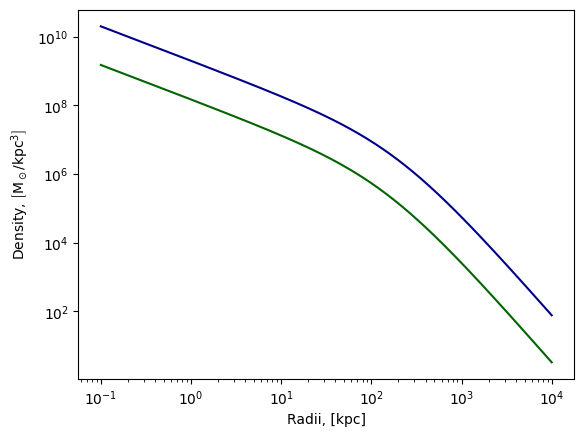

In [7]:
# Plot the two profiles over a characteristic range of radii.
x = np.geomspace(1e-1, 1e4, 1000)
halo_density, gas_density = halo_profile(x), gas_profile(x)

fig, axes = plt.subplots(1, 1)

axes.loglog(x, halo_density, color="darkblue", label=r"$\rho_{\rm DM}(r)$")
axes.loglog(x, gas_density, color="darkgreen", label=r"$\rho_{\rm g}(r)$")
axes.set_xlabel("Radii, [kpc]")
axes.set_ylabel(r"Density, $\left[{\rm M_\odot / kpc^3}\right]$")

With the profiles and the coordinate system in place, we're ready to generate our model:

In [8]:
cluster_model = ClusterModel.from_dens_and_tden(
    "cluster_model.hdf5",
    1e-1,
    1e4,
    gas_profile,
    halo_profile,
    1000,
    coordinate_system=coordinate_system,
)

ClusterModel : [INFO     ] [BLDR] Building model skeleton at path: cluster_model.hdf5
ClusterModel : [DEBUG    ] [BLDR] HDF5 file created successfully.
ClusterModel : [DEBUG    ] [BLDR] Grid manager skeleton built successfully.
ClusterModel : [DEBUG    ] Profile 'gas_density' added successfully.
ClusterModel : [DEBUG    ] Profile 'total_density' added successfully.
ClusterModel : [INFO     ] [BLDR] Model skeleton created successfully at 'cluster_model.hdf5'.
ClusterModel : [INFO     ] [LOAD] Loading model from file: cluster_model.hdf5...
Pisces : [INFO     ] 2025-01-07 14:10:21,436 Preparing Lame Coefficients for SphericalCoordinateSystem instance. This may take a few seconds...
Pisces : [INFO     ] 2025-01-07 14:10:21,446 Preparing derived attributes for SphericalCoordinateSystem instance. This may take a few seconds...
Pisces : [INFO     ] 2025-01-07 14:10:21,450 Lambdifying attributes...
ClusterModel : [INFO     ] [LOAD] COMPLETE: cluster_model.hdf5
ClusterModel : [INFO     ] [EXEC]

[EXEC]:   0%|          | 0/6 [00:00<?, ?it/s]

ClusterModel : [INFO     ] [EXEC] 	(1/6) START: `convert_profiles_to_fields`.
ClusterModel : [DEBUG    ] [EXEC] 		Added field `gas_density` (units=Msun/kpc**3) from profile.
ClusterModel : [DEBUG    ] [EXEC] 		Added field `total_density` (units=Msun/kpc**3) from profile.
ClusterModel : [DEBUG    ] [EXEC] 		Added field `stellar_density` (units=Msun/kpc**3) as null.
ClusterModel : [INFO     ] [EXEC] 	(1/6) COMPLETE: `convert_profiles_to_fields`.
ClusterModel : [INFO     ] [EXEC] 	(2/6) START: `perform_mass_accounting`.
ClusterModel : [DEBUG    ] [EXEC] Added field 'dark_matter_density' (units=Msun/kpc**3, ndim=1).
ClusterModel : [INFO     ] [EXEC] 	(2/6) COMPLETE: `perform_mass_accounting`.
ClusterModel : [INFO     ] [EXEC] 	(3/6) START: `integrate_density_fields`.
ClusterModel : [INFO     ] [EXEC] 	(3/6) COMPLETE: `integrate_density_fields`.
ClusterModel : [INFO     ] [EXEC] 	(4/6) START: `solve_poisson_problem`.
ClusterModel : [DEBUG    ] [EXEC] Added field 'gravitational_potential' (u

The output above tells us exactly what steps were taken to solve to problem:

1. The profiles $\rho_g$ and $\rho_{\rm dyn}$ were added to the cluster as fields.
2. We then used "mass accounting" to construct $\rho_{\star}$ (which is zero here because we didn't provide it), and $\rho_{\rm dm}$.
3. We integrated all of those density profiles to generate the mass profiles.
4. We solved the Poisson problem to get $\Phi$ and $\nabla \Phi$.
5. We solved the HSE equation

   $$ \frac{\nabla P}{\rho_g} = - \nabla \Phi. $$

6. We used $P$ and $\rho_g$ to compute the temperature.

Now we can take a look at the results! First off, let's take a look at a slice through the cluster of the temperature.

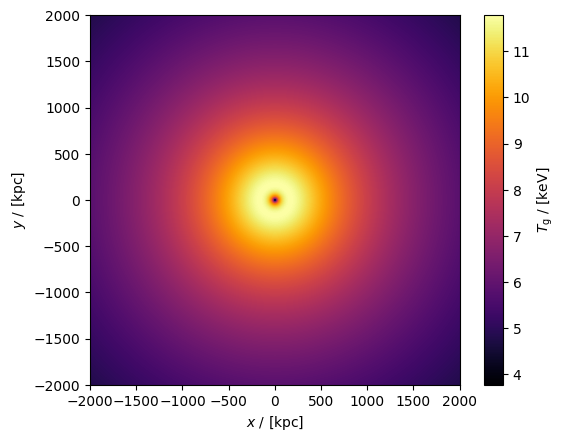

In [11]:
# Set the extent of the image (in kpc)
extent = [-2000, 2000, -2000, 2000]

# Create the plot.
cluster_model.plot_slice("temperature", extent, cmap="inferno")

# show the plot.
plt.show()

You can also easily create a 1-D plot of the temperature profile and total mass as a function of the radius:

Text(0.5, 0, 'Radius, [kpc]')

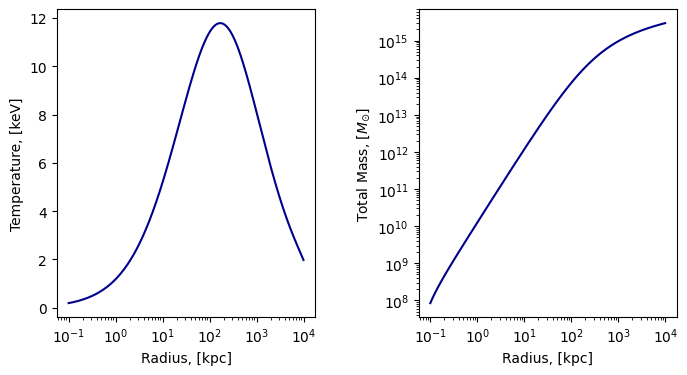

In [26]:
# Fetch the radii of the model from its grid manager.
radii = cluster_model.get_radii()  # 1-D array of radii.

# Fetch the temperature field data.
temperature_data = cluster_model.FIELDS["temperature"][...]
mass_data = cluster_model.FIELDS["total_mass"][...]

# Create a plot of the two datasets.
fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(wspace=0.4))

axes[0].semilogx(radii, temperature_data, color="darkblue")
axes[0].set_ylabel("Temperature, [keV]")
axes[0].set_xlabel("Radius, [kpc]")

axes[1].loglog(radii, mass_data, color="darkblue")
axes[1].set_ylabel(r"Total Mass, $[M_{\odot}]$")
axes[1].set_xlabel("Radius, [kpc]")